# Inferring velocity dispersions of Kepler stars using HBM.

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [7]:
gaia_mc0 = pd.read_csv("../data/gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
bmin = 10
m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]
N = len(gaia_mc)
print(N, "stars")

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(4635, 133) no high latitude stars
4635 stars


In [8]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
vb = gaia_mc.vb.values
vb_err = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
b = gaia_mc.b.values
print(np.shape(vb), np.shape(b))

(4635,) (4635,)


In [9]:
xlim = (maxt + 100, mint - 200)
tbins = np.linspace(min(x), max(x), 10)

period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [10]:
def sample_model(N, vb, vb_err, b, beta=.52, slope=.44, intercept=.15):

    # Hierarchical model
    simple_model = pm.Model()

    with simple_model:
    
            # Prior over mu
            mu = pm.Uniform("mu", lower=-100, upper=100)
        
            # Prior over sigma
            sigma = pm.Uniform("sigma", lower=0, upper=100)
        
            # vz
            vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N)
        
            # vb (the likelihood)
            vb_hat = pm.Normal("vb_hat", mu=vz_hat,  # sigma=vb_err + (slope*b + intercept),
                               sigma=np.sqrt(vb_err**2 + (slope*b+intercept)**2),
                               observed=vb)
        
    # Sample
    with simple_model:
        trace = pm.sample(tune=5000, draws=5000)
    return trace

variance of marginalised gaussian is the inverse of the sum of inverse variances.

sigma**2 = (1./sigma1**2 + 1./sigma2**2)**-1

mu1/sigma1**2 + mu2/sigma2**2/(1./sigma)

In [11]:

print(tbins)

[3501.71336315 3723.34219794 3944.97103274 4166.59986753 4388.22870232
 4609.85753712 4831.48637191 5053.1152067  5274.74404149 5496.37287629]


In [22]:
from statsmodels.stats.weightstats import DescrStatsW

slope, intercept =.44, .15
vb_errs_inflated = np.sqrt(vb_err**2 + (slope*b + intercept)**2)

pds, pderrs = [np.zeros((len(mid_period_bins), len(tbins[:-1]))) for i in range(2)]

for i, m in enumerate(period_masks):
#     print(i, "of", len(period_masks))

    for j in range(len(tbins)-1):
#         print(j, "of", len(tbins))
        m2 = (tbins[j] < x[m]) * (x[m] < tbins[j+1])
        weighted_stats = DescrStatsW(vb[m][m2], weights=vb_errs_inflated[m][m2], ddof=0)
        pds[i, j] = weighted_stats.std

#         if sum(m2) > 0:
#             trace = sample_model(len(vb[m][m2]), vb[m][m2], vb_err[m][m2], b[m][m2])
    
#             pds[i, j] = np.median(trace.sigma)
#             pderrs[i, j] = np.std(trace.sigma)

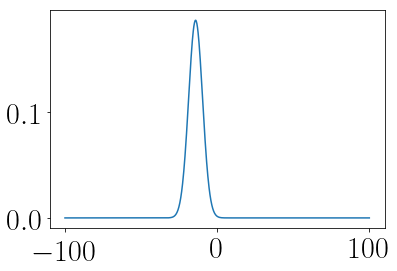

In [20]:
slope, intercept =.44, .15

def p_vz(vb, vz, sigma_b, sigma_vb):
    var = sigma_b**2 + sigma_vb**2
    sig = np.sqrt(var)
    return 1./np.sqrt(2*np.pi*sig) * np.exp(-.5*(vb - vz)**2/var)

vzs = np.linspace(-100, 100, 1000)
plt.plot(vzs, p_vz(vb[0], vzs, slope*b[0]+intercept, vb_err[0]))

In [23]:
cmap = plt.cm.get_cmap('viridis_r')

pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

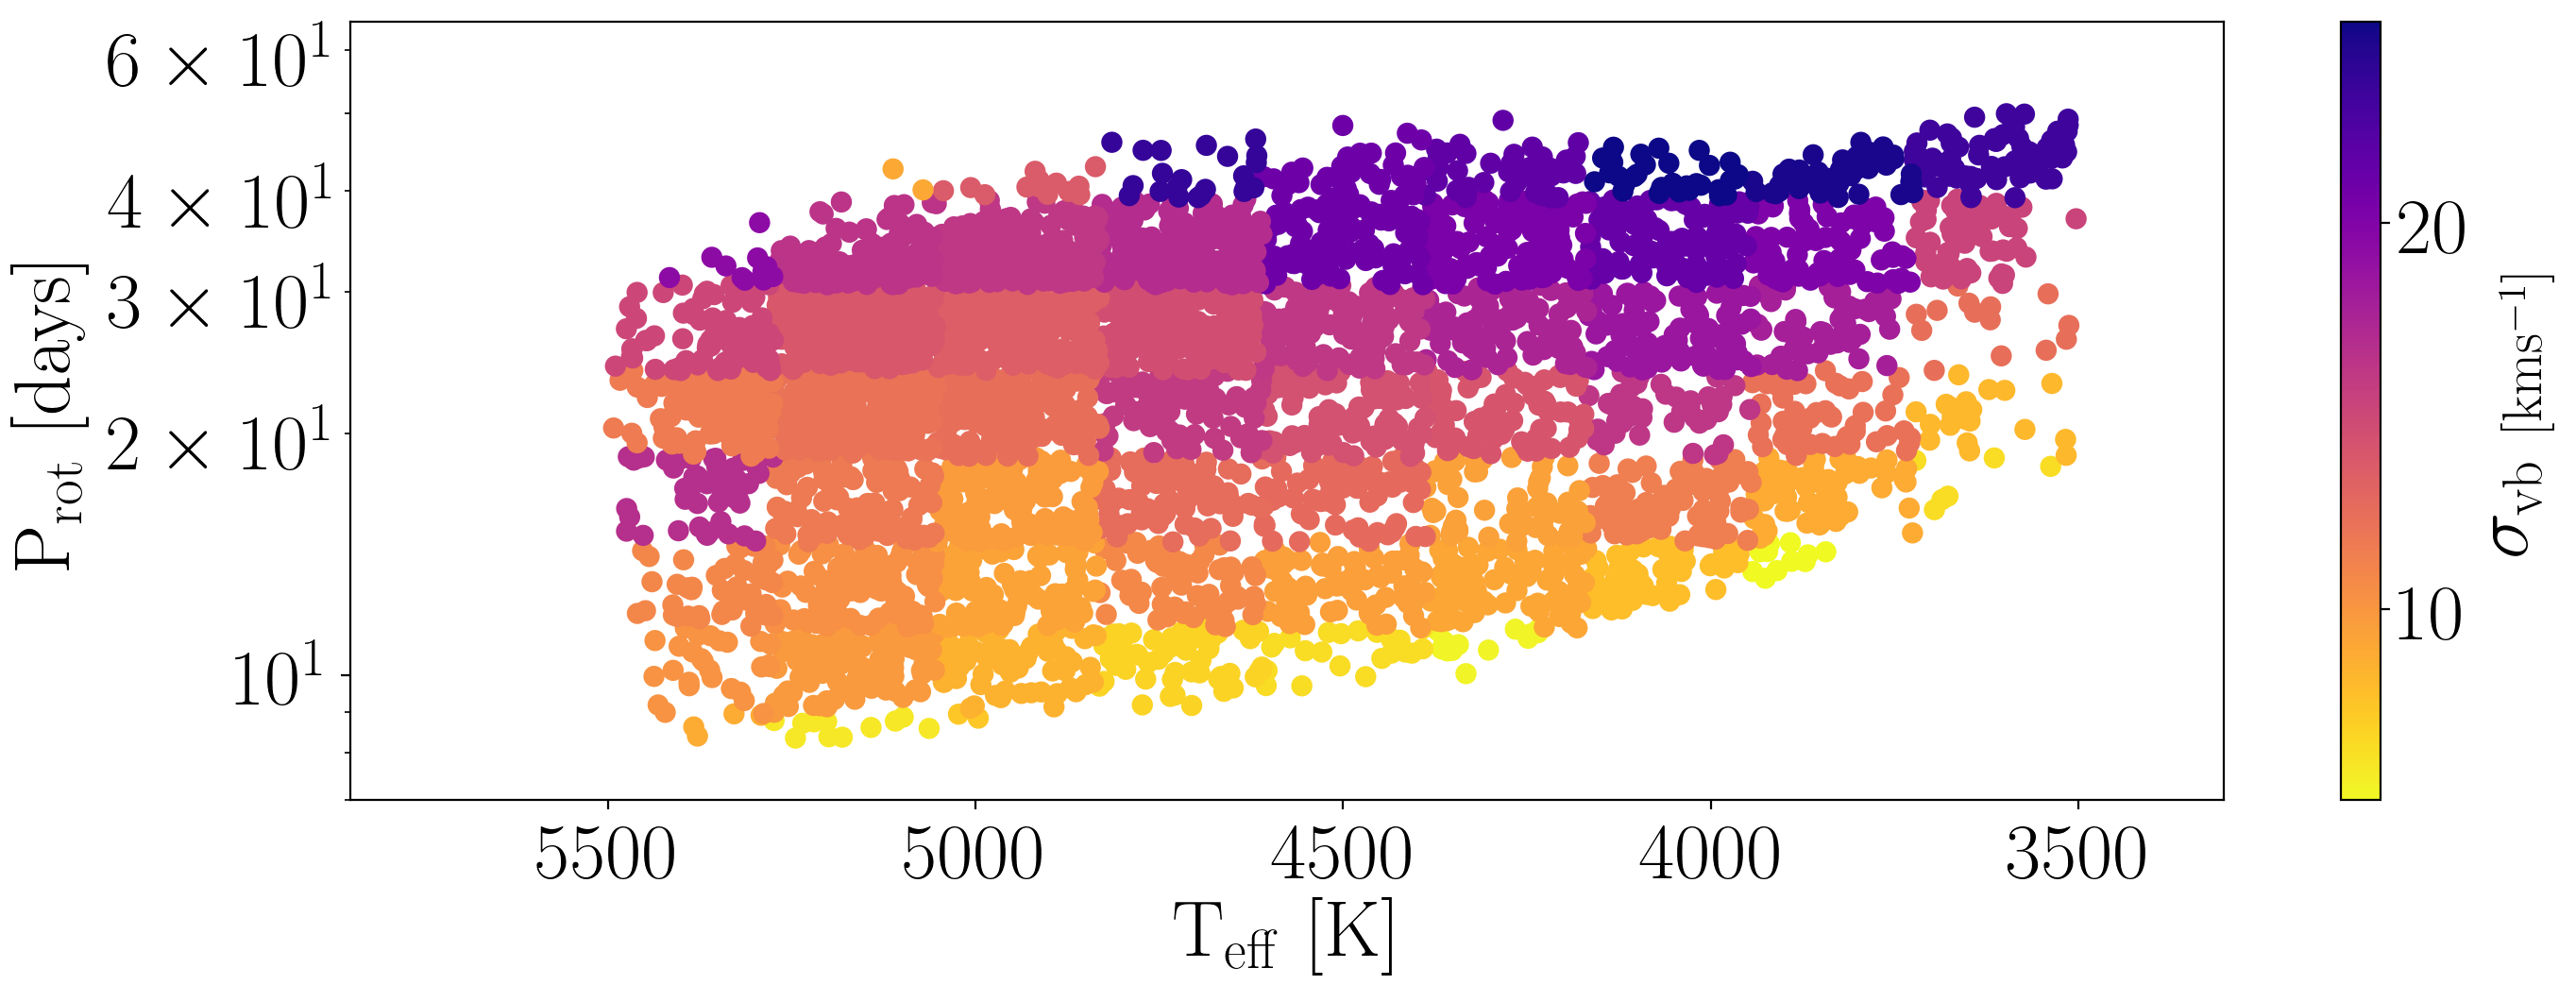

In [24]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50, cmap="plasma_r")   
        
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax1.set_xlim(5850, min(x)-200)
ax1.set_yscale("log")
ax1.set_ylim(7, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")

$$ \sigma = t^\beta$$
$$t = \sigma^{1/\beta}$$

In [25]:
def sig_to_age(sig):
    c = 1 - .53 * np.log(1.5)
    logage = (np.log10(sig) - c) / .53
    return 10**logage

ads = sig_to_age(pds)
amin, amax = np.min(ads[ads > 0]), np.max(ads[np.isfinite(ads)])

Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

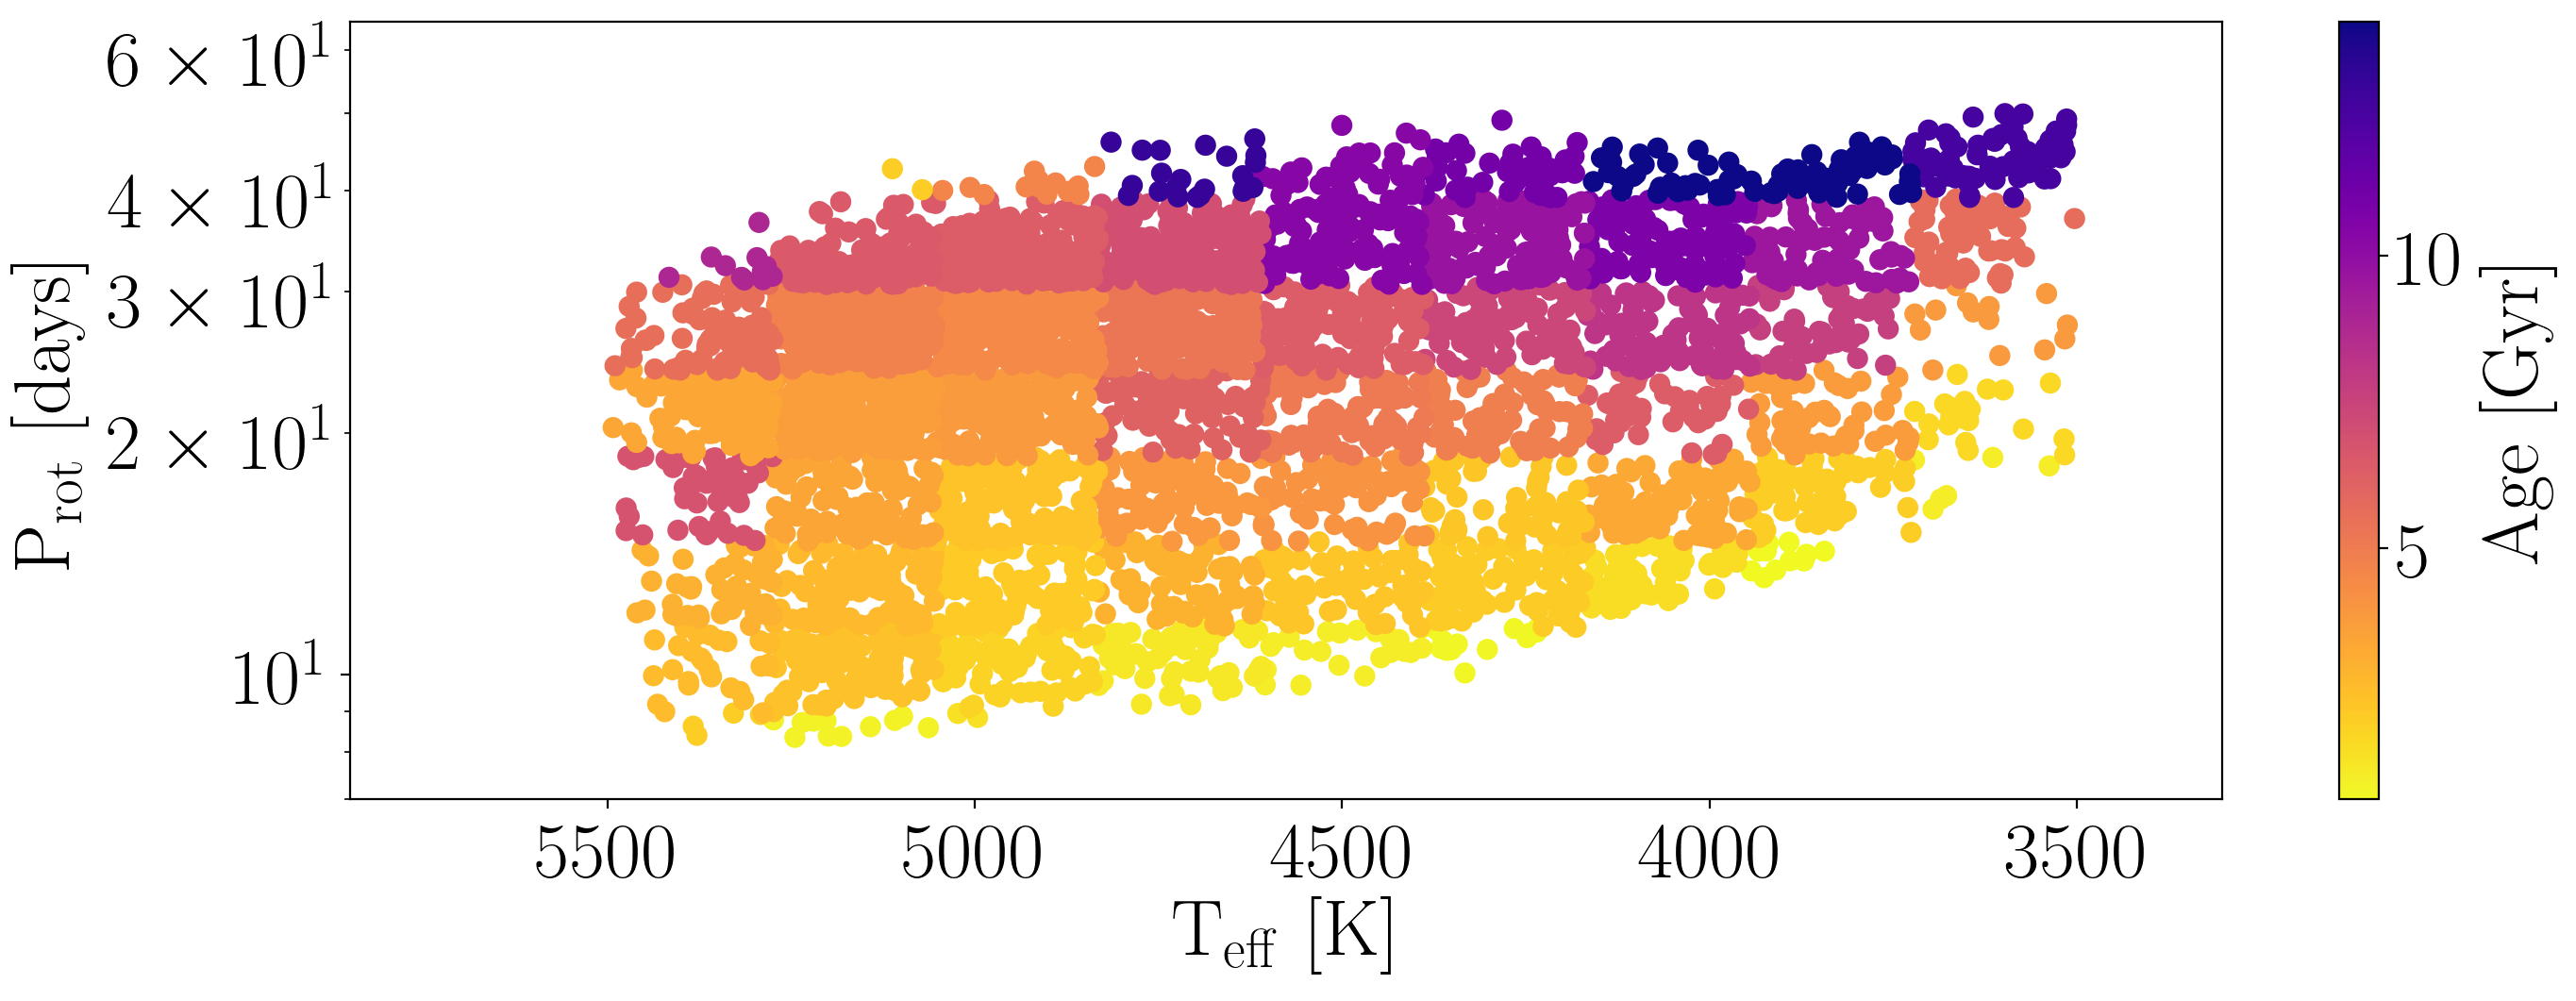

In [27]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*ads[i, j],
                          vmin=amin, vmax=14, rasterized=True, zorder=1, s=50, cmap="plasma_r")   
        
plt.colorbar(cb1, label="$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax1.set_xlim(5850, min(x)-200)
ax1.set_yscale("log")
ax1.set_ylim(7, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")